In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
df = pd.read_csv('Electric_Production.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
value_col = 'IPG2211A2N'

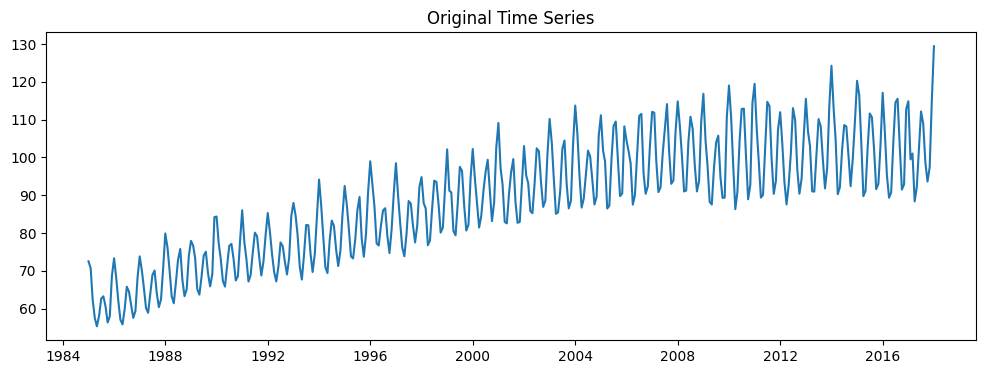

ADF Statistic: -2.256990350047235
p-value: 0.1862146911658712
ADF Statistic: -7.104890882267311
p-value: 4.0777865655394095e-10
Differencing order (d): 1


In [5]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] <= 0.05  # Returns True if stationary (p-value < 0.05)

# Initial visualization
plt.figure(figsize=(12, 4))
plt.plot(df[value_col])
plt.title('Original Time Series')
plt.show()
is_stationary = check_stationarity(df[value_col])
d = 0
if not is_stationary:
    diff_series = df[value_col].diff().dropna()
    is_stationary = check_stationarity(diff_series)
    d = 1
    if not is_stationary:
        diff_series = diff_series.diff().dropna()
        d = 2

print(f'Differencing order (d): {d}')

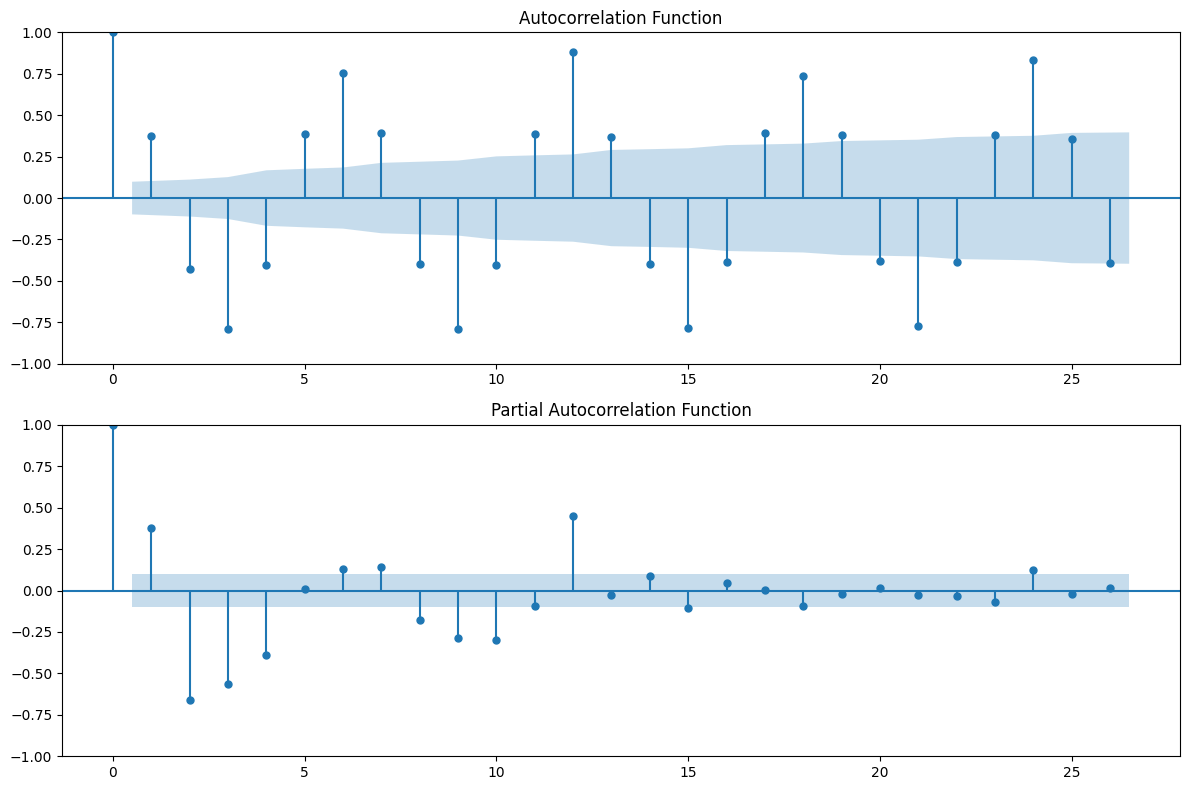

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df[value_col].diff(d).dropna(), ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(df[value_col].diff(d).dropna(), ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [7]:
p = 1
q = 1
arima_model = ARIMA(df[value_col], order=(p, d, q))
arima_results = arima_model.fit()
print('\nARIMA Model Summary:')
print(arima_results.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1308.795
Date:                Tue, 01 Apr 2025   AIC                           2623.589
Time:                        12:29:37   BIC                           2635.533
Sample:                    01-01-1985   HQIC                          2628.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.091      0.805      0.421      -0.105       0.251
ma.L1          0.5450      0.070      7.737      0.000       0.407       0.683
sigma2        43.4248      3.2

In [8]:
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
s = 12 # Seasonal period (monthly data)

sarima_model = SARIMAX(df[value_col],
                      order=(p, d, q),
                      seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()
print('\nSARIMA Model Summary:')
print(sarima_results.summary())


SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         IPG2211A2N   No. Observations:                  397
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -888.613
Date:                            Tue, 01 Apr 2025   AIC                           1787.226
Time:                                    12:30:37   BIC                           1806.979
Sample:                                01-01-1985   HQIC                          1795.061
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5249      0.045     11.764      0.000       0.437       0.612
ma.L1       

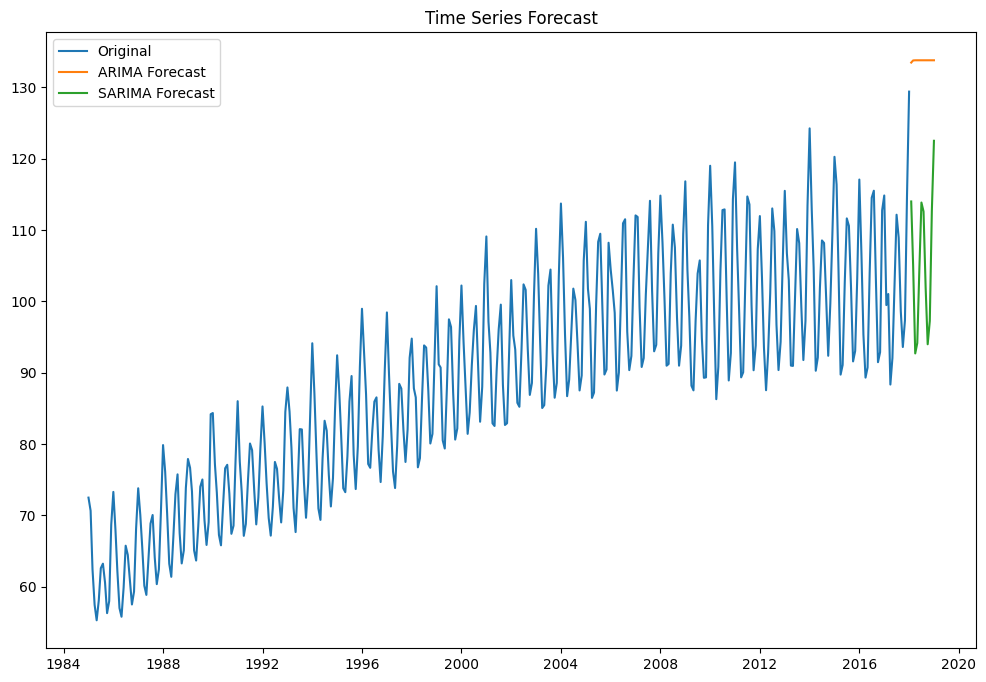


ARIMA RMSE: 8.09
SARIMA RMSE: 3.10


In [9]:
forecast_steps = 12  # Forecast 12 months ahead
arima_forecast = arima_results.forecast(steps=forecast_steps)
sarima_forecast = sarima_results.forecast(steps=forecast_steps)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(df[value_col], label='Original')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(sarima_forecast, label='SARIMA Forecast')
plt.title('Time Series Forecast')
plt.legend()
plt.show()

# Calculate and print forecast errors
train_size = int(len(df) * 0.8)
train, test = df[value_col][:train_size], df[value_col][train_size:]
arima_pred = arima_results.predict(start=train_size, end=len(df)-1)
sarima_pred = sarima_results.predict(start=train_size, end=len(df)-1)

arima_rmse = np.sqrt(np.mean((test - arima_pred)**2))
sarima_rmse = np.sqrt(np.mean((test - sarima_pred)**2))

print(f'\nARIMA RMSE: {arima_rmse:.2f}')
print(f'SARIMA RMSE: {sarima_rmse:.2f}')